# Plot data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [2]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10,3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0,len(wav)+1, 1000), [x/1000 for x in np.arange(0,len(wav)+1, 1000)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

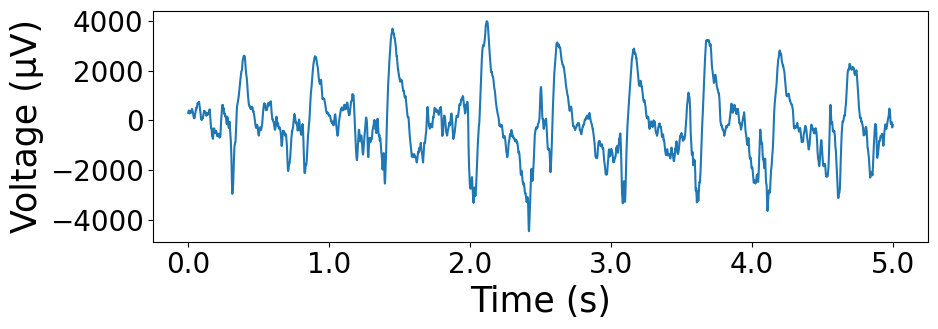

In [3]:
data_path = "/mnt/AI_Magic/projects/iEEG_data/ucla/EEG_Data_90min/brainBERT_data/Pt1_AR_POL G23_21.npy"
plot_time_series(data_path)

In [4]:
np.load("/mnt/AI_Magic/projects/iEEG_data/ucla/EEG_Data_90min/brainBERT_data/Pt1_AR_POL G23_21.npy").shape

(5000,)

In [3]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")
   
    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")

    Zxx = np.abs(Zxx)
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")
    
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip])
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip])
        t = t[clip:-clip]
        
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace()

    return f, t, Zxx

def plot_stft(t,f,linear, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,3))
        
    g1 = ax.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1, ax=ax)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_ylabel("Frequency (Hz)", fontsize=15)
    ax.set_title(title, fontsize=15)

def plot_wav(wav):
    f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
    plot_stft(t,f,linear)

def plot_wav_from_file(path):
    wav = np.load(path)
    plot_wav(wav)

# Load model

In [4]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream, upstream_cfg

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [5]:
from omegaconf import OmegaConf

device = "cuda:1"
ckpt_path = "../pretrained_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model, upstream_cfg = build_model(cfg)
model.to(device)
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state['model'], False)

In [8]:
upstream_cfg

{'name': 'masked_tf_model', 'hidden_dim': 768, 'layer_dim_feedforward': 3072, 'layer_activation': 'gelu', 'nhead': 12, 'encoder_num_layers': 6, 'input_dim': 40}

# Get output

In [9]:
wav = np.load(data_path)
f,t,linear = get_stft(wav, 1000, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to(device)
mask = torch.zeros((inputs.shape[:2])).bool().to(device)

print(inputs.shape)
print(mask.shape)

with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=False)

Shape of Zxx: (201, 101), shape of f: (201,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 91), shape of f: (40,), shape of t: (91,)
torch.Size([1, 91, 40])
torch.Size([1, 91])


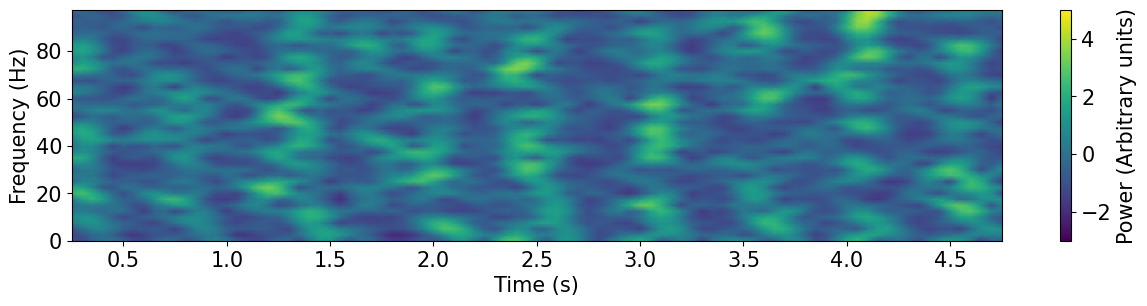

In [10]:
plot_stft(t,f,linear)

In [11]:
recovery = out[0][0].cpu().numpy().transpose(1,0)
plot_stft(t,f,recovery)

In [ ]:
np.mean(np.abs(recovery - linear)) / np.mean(np.abs(linear))

0.145822146022644

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

from datasets.masked_tf_dataset import *
from omegaconf import OmegaConf

/home/capur/mambaforge/envs/brainbert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
dataset_cfg = OmegaConf.load("../conf/data/masked_tf_dataset.yaml")
task_cfg = OmegaConf.load("../conf/task/fixed_mask_pretrain.yaml")
preprocessor_cfg = OmegaConf.load("../conf/preprocessor/stft.yaml")
dataset_cfg["data"] = "/mnt/AI_Magic/projects/iEEG_data/spindles/np_2kHz_segmented_laplacian/Th_proj_Pt9"
dataset_cfg["use_mask"] = False

dataset = MaskedTFDataset(dataset_cfg, task_cfg=task_cfg, preprocessor_cfg=preprocessor_cfg)

In [11]:
task_cfg

{'name': 'spec_pretrain', 'mask_type': 'fixed', 'time_mask_consecutive_min': 1, 'time_mask_consecutive_max': 5, 'freq_mask_consecutive_min': 1, 'freq_mask_consecutive_max': 2, 'time_mask_p': 0.1, 'freq_mask_p': 0.1}

In [14]:
dataset_cfg

{'name': 'masked_tf_dataset', 'val_split': 0.1, 'data': '/mnt/AI_Magic/projects/iEEG_data/spindles/np_2kHz_segmented_laplacian/Th_proj_Pt9', 'preprocessor': 'stft', 'use_mask': False}

In [12]:
from tqdm import tqdm
stats = []
samples = []

for sample in tqdm(dataset):
    inputs = torch.FloatTensor(sample["masked_input"]).unsqueeze(0).to(device)
    mask = torch.FloatTensor(sample["mask_label"]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_out = model.forward(inputs, mask, intermediate_rep=False)
        embed_out = model.forward(inputs, mask, intermediate_rep=True)
        
    original = sample["target"].cpu().numpy()
    recovery = pred_out[0][0].cpu().numpy()
    embedding = embed_out[0][0].cpu().numpy()
    
    mean = sample["mean"]
    std = sample["std"]
    un_normalized_data = sample["un_normalized_target"]
    wav = sample["wav"]
    erased_Zxx = sample["erased_Zxx"]
    fn = sample["fn"]
    
    stats += [np.mean(np.abs(recovery - original)) / np.mean(np.abs(original))]
    samples += [[sample["masked_input"].cpu().numpy(), 
                 sample["target"].cpu().numpy(), 
                 recovery,
                 embedding,
                 sample["freq"], 
                 sample["time"], 
                 np.mean(np.abs(recovery - original)) / np.mean(np.abs(original)), 
                 mean, 
                 std, 
                 un_normalized_data, 
                 wav, 
                 erased_Zxx,
                 fn]]


  0%|          | 0/2199 [00:00<?, ?it/s]

100%|██████████| 2199/2199 [00:48<00:00, 45.29it/s]


In [20]:
import pandas as pd
samples_df = pd.DataFrame(samples, columns=["masked_input", "target", "recovery", "embedding", "freq", "time", "error", "mean", "std", "un_normalized_data", "wav", "erased_Zxx", "fn"])
samples_df["label"] = samples_df["fn"].apply(lambda x: x.split("/")[1])

In [24]:
samples[0][3].shape

(768,)

In [22]:
samples_df["label"].value_counts()

label
0    1919
1     280
Name: count, dtype: int64

In [23]:
samples_df.to_csv("../results/stft_large_pretrained_Th_proj_Pt9.csv", index=False)

In [52]:
data = np.array(samples_df["embedding"].tolist())
labels = np.array(samples_df["label"].tolist()).astype(int)

In [53]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([1919,  280]))

Epoch [1/100], Loss: 0.6977
Epoch [2/100], Loss: 0.6163
Epoch [3/100], Loss: 0.5932
Epoch [4/100], Loss: 0.5195
Epoch [5/100], Loss: 0.6196
Epoch [6/100], Loss: 0.6182
Epoch [7/100], Loss: 0.4622
Epoch [8/100], Loss: 0.4895
Epoch [9/100], Loss: 0.4296
Epoch [10/100], Loss: 0.5572
Epoch [11/100], Loss: 0.3738
Epoch [12/100], Loss: 0.3387
Epoch [13/100], Loss: 0.3522
Epoch [14/100], Loss: 0.4599
Epoch [15/100], Loss: 0.3786
Epoch [16/100], Loss: 0.3875
Epoch [17/100], Loss: 0.3805
Epoch [18/100], Loss: 0.3479
Epoch [19/100], Loss: 0.2452
Epoch [20/100], Loss: 0.2903
Epoch [21/100], Loss: 0.3483
Epoch [22/100], Loss: 0.3087
Epoch [23/100], Loss: 0.1626
Epoch [24/100], Loss: 0.2360
Epoch [25/100], Loss: 0.2799
Epoch [26/100], Loss: 0.1645
Epoch [27/100], Loss: 0.1272
Epoch [28/100], Loss: 0.0942
Epoch [29/100], Loss: 0.1561
Epoch [30/100], Loss: 0.1701
Epoch [31/100], Loss: 0.1746
Epoch [32/100], Loss: 0.1904
Epoch [33/100], Loss: 0.1395
Epoch [34/100], Loss: 0.1385
Epoch [35/100], Loss: 0

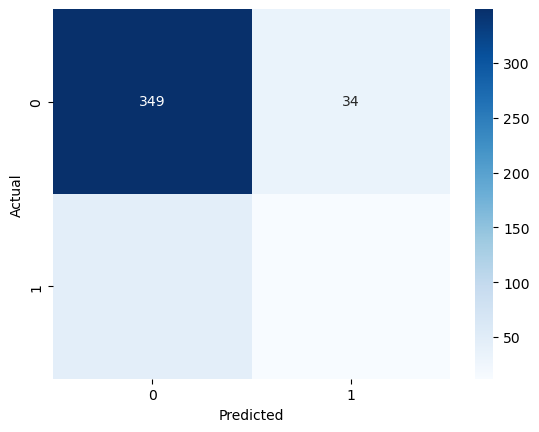

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# Example dataset (X: features, y: labels)
X = torch.FloatTensor(data)  # Features
y = torch.FloatTensor(labels).to(int)  # Labels

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate weights for each sample
class_sample_count = torch.tensor([(y_train == t).sum() for t in torch.unique(y_train, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in y_train])

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Creating DataLoaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = BinaryClassifier()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    gt = []
    pred = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        gt += labels.tolist()
        pred += predicted.tolist()


# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(gt, pred)
# Plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

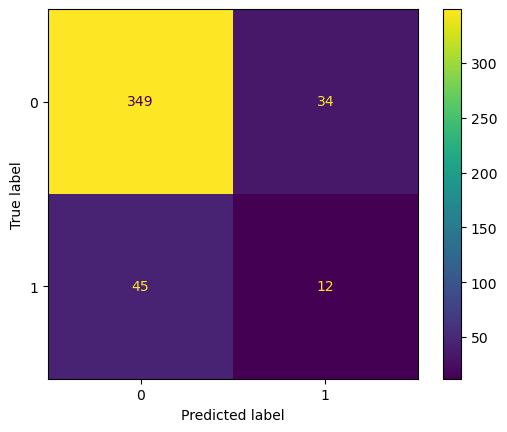

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0, 1])
disp.plot()
plt.show()

In [126]:
import numpy as np
import plotly.express as px
from sklearn import datasets
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = data
y = labels

# Perform t-SNE and UMAP transformations
tsne = TSNE(n_components=3, random_state=42)
umap = umap.UMAP(n_components=3, random_state=42)

X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

# Create dataframes for Plotly
df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
df_tsne['Target'] = y
df_umap = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2', 'Dim3'])
df_umap['Target'] = y

# Create 3D scatter plots using Plotly
fig_tsne = px.scatter_3d(df_tsne, x='Dim1', y='Dim2', z='Dim3', color='Target', 
                         labels={'Target': 'Class'}, title='t-SNE Projection', opacity=0.7)
fig_umap = px.scatter_3d(df_umap, x='Dim1', y='Dim2', z='Dim3', color='Target', 
                         labels={'Target': 'Class'}, title='UMAP Projection', opacity=0.7)


print(f"t-SNE x-axis range: {xlim_tsne}, y-axis range: {ylim_tsne}, z-axis range: {zlim_tsne}")
print(f"UMAP x-axis range: {xlim_umap}, y-axis range: {ylim_umap}, z-axis range: {zlim_umap}")

def gen_range_ticks(data):
    xrange = [np.min(data), np.max(data)]
    xrange_ticks = np.linspace(xrange[0], xrange[1], 11)
    return xrange, xrange_ticks

x_range_tsne, x_range_ticks_tsne = gen_range_ticks(X_tsne[:,0])
y_range_tsne, y_range_ticks_tsne = gen_range_ticks(X_tsne[:,1])
z_range_tsne, z_range_ticks_tsne = gen_range_ticks(X_tsne[:,2])

fig_tsne.update_layout(
    scene = dict(
        aspectmode  = 'cube',
        aspectratio = dict(x=1, y=1, z=1),
        xaxis = dict(nticks=11, tickvals=x_range_ticks_tsne, ticktext=np.round(x_range_ticks_tsne, 1), range=x_range_tsne,),
        yaxis = dict(nticks=11, tickvals=y_range_ticks_tsne, ticktext=np.round(y_range_ticks_tsne, 1), range=y_range_tsne,),
        zaxis = dict(nticks=11, tickvals=z_range_ticks_tsne, ticktext=np.round(z_range_ticks_tsne, 1), range=z_range_tsne,),
        ),
    width=1600,
)
fig_tsne.update_scenes(
    xaxis_autorange=False,
    yaxis_autorange=False,
    zaxis_autorange=False,
)

x_range_umap, x_range_ticks_umap = gen_range_ticks(X_umap[:,0])
y_range_umap, y_range_ticks_umap = gen_range_ticks(X_umap[:,1])
z_range_umap, z_range_ticks_umap = gen_range_ticks(X_umap[:,2])

fig_umap.update_layout(
    scene = dict(
        aspectmode  = 'cube',
        aspectratio = dict(x=1, y=1, z=1),
        xaxis = dict(nticks=11, tickvals=x_range_ticks_umap, ticktext=np.round(x_range_ticks_umap, 1), range=x_range_umap,),
        yaxis = dict(nticks=11, tickvals=y_range_ticks_umap, ticktext=np.round(y_range_ticks_umap, 1), range=y_range_umap,),
        zaxis = dict(nticks=11, tickvals=z_range_ticks_umap, ticktext=np.round(z_range_ticks_umap, 1), range=z_range_umap,),
        ),
    width=1600,
)
fig_umap.update_scenes(
    xaxis_autorange=False,
    yaxis_autorange=False,
    zaxis_autorange=False,
)

# Show the plots
fig_tsne.show()
fig_umap.show()

/home/capur/mambaforge/envs/brainbert/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



t-SNE x-axis range: [0.0, 1.0000001], y-axis range: [0.0, 1.0], z-axis range: [0.0, 1.0]
UMAP x-axis range: [0.0, 1.0], y-axis range: [0.0, 1.0000001], z-axis range: [0.0, 0.9999999]


0.5083749


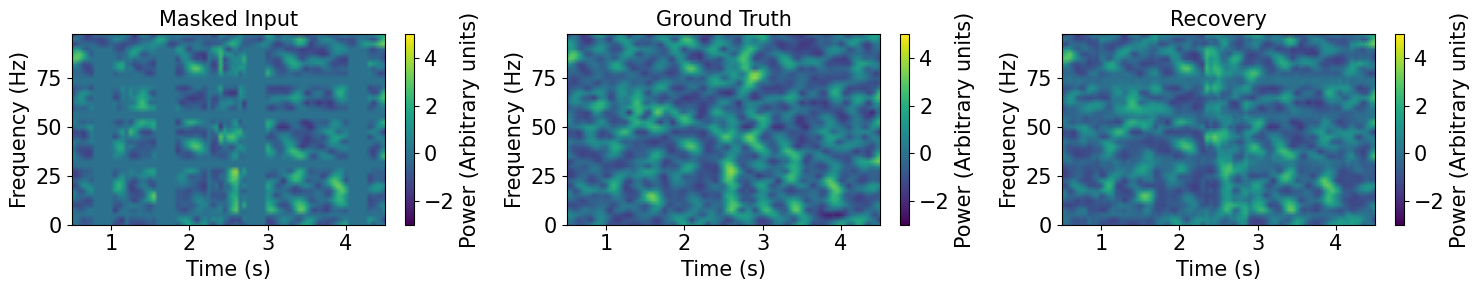

In [ ]:
# find samples with error around 0.2

find_num = 0.5
ok_samples = samples_df[(samples_df["error"] > find_num - 0.01) & (samples_df["error"] < find_num + 0.01)].iloc[0].copy()

print(ok_samples["error"])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

plot_stft(ok_samples["time"], ok_samples["freq"], ok_samples["masked_input"].transpose(1,0), "Masked Input", ax=ax[0])

plot_stft(ok_samples["time"], ok_samples["freq"], ok_samples["target"].transpose(1,0), "Ground Truth", ax=ax[1])

plot_stft(ok_samples["time"], ok_samples["freq"], ok_samples["recovery"].transpose(1,0), "Recovery", ax=ax[2])

plt.tight_layout()

In [ ]:
masked_input_data.shape

(40, 81)

In [20]:
ok_samples

masked_input          [[-1.2498882, 0.60050154, -1.2525191, -0.49913...
target                [[-1.2498882, 0.60050154, -1.2525191, -0.49913...
recovery              [[-1.1335715, 0.4972827, -1.2495196, -0.292262...
freq                  [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 2...
time                  [0.49999999999999994, 0.55, 0.6000000000000001...
error                                                          0.191318
mean                  [[375.98846], [374.20795], [270.72958], [239.8...
std                   [[257.21115], [224.85666], [147.50896], [130.3...
un_normalized_data    [[54.5033, 509.2347, 85.97179, 174.79445, 48.4...
wav                   [-340.5373, -360.72113, -411.11575, -513.4247,...
erased_Zxx            [[2.1396914, 1.675452, 0.78731513, 1.7466632, ...
Name: 2, dtype: object

0.3959341


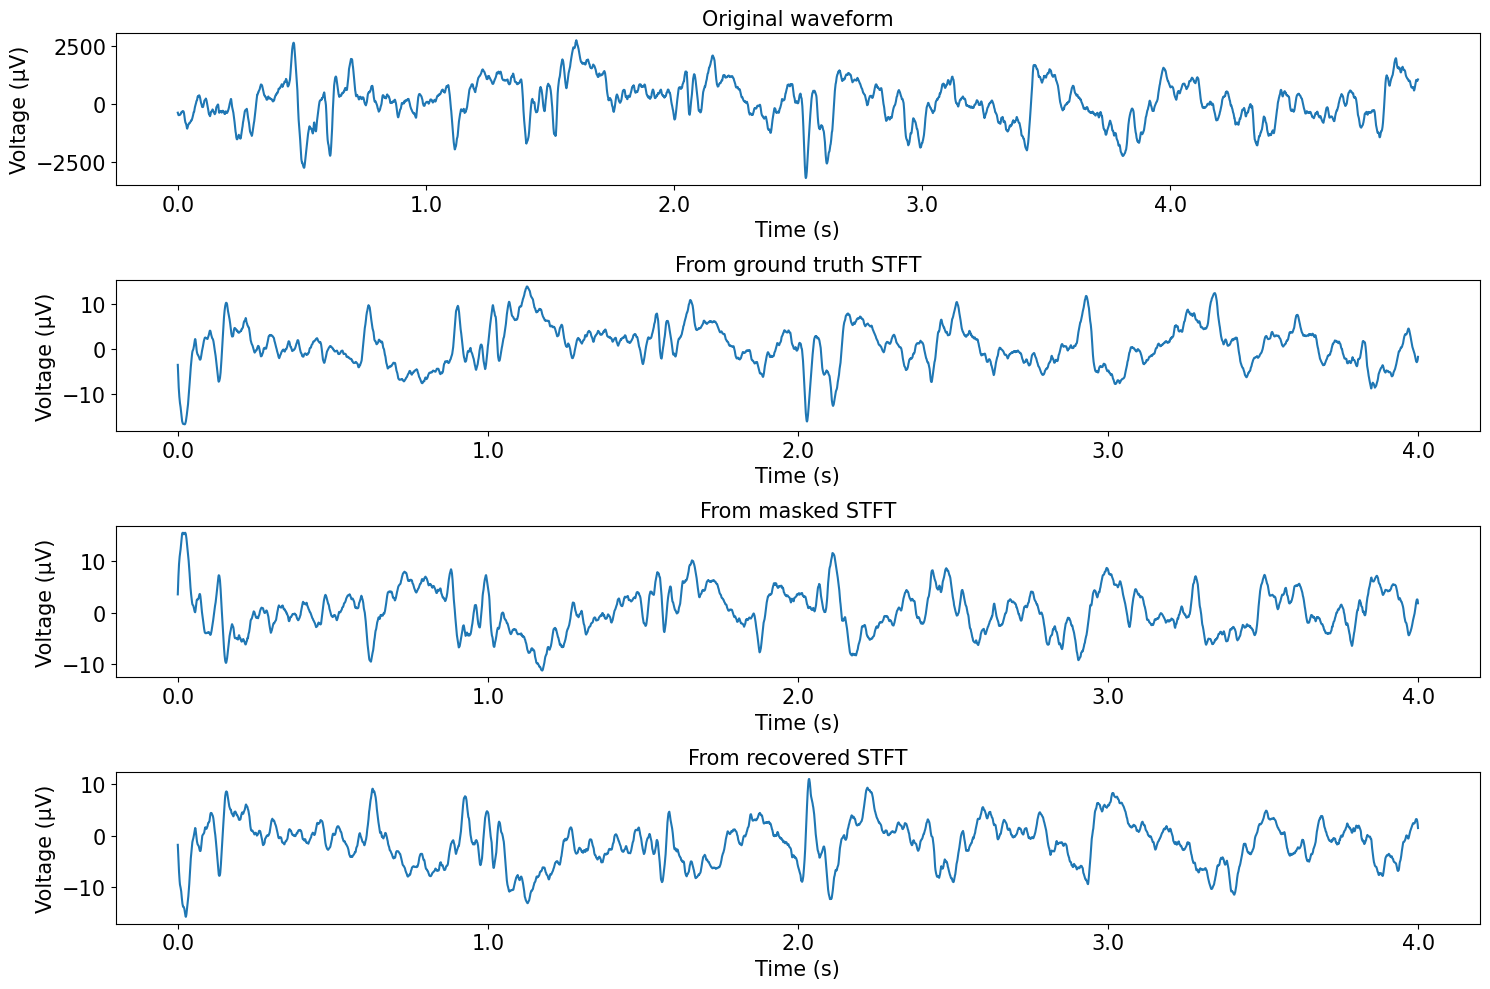

In [28]:
def reverse_zscore(z, mn, std):
    """
    Reverses the z-scoring operation to get the original values.
    
    Parameters:
    - z: The z-scored array
    - mn: Original mean values used for z-scoring
    - std: Original standard deviation values used for z-scoring
    
    Returns:
    - Original array before z-scoring
    """
    return (z * std) + mn

# find samples with error around find_num
find_num = 0.4
ok_samples = samples_df[(samples_df["error"] > find_num - 0.01) & (samples_df["error"] < find_num + 0.01)].iloc[0].copy()

masked_input_data = ok_samples["masked_input"].transpose(1,0)
gt_data = ok_samples["target"].transpose(1,0)
un_normalized_data = ok_samples["un_normalized_data"].transpose(1,0)
recovery = ok_samples["recovery"].transpose(1,0)

print(ok_samples["error"])

reversed_input = reverse_zscore(gt_data, ok_samples["mean"], ok_samples["std"])
reversed_masked = reverse_zscore(masked_input_data, ok_samples["mean"], ok_samples["std"])
reversed_recover = reverse_zscore(recovery, ok_samples["mean"], ok_samples["std"])

# Reverse the cutoff operation, add 160 x 81 zeros to the end of the array
erased_Zxx = ok_samples["erased_Zxx"]
reversed_input = np.concatenate([reversed_input, erased_Zxx], axis=0)
reversed_masked = np.concatenate([reversed_masked, erased_Zxx], axis=0)
reversed_recover = np.concatenate([reversed_recover, erased_Zxx], axis=0)

# Use griffin-lim to recover the original signal

import librosa

def plot_wav(wav, ax, title):
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(u"Voltage (\u03bcV)", fontsize=15)
    ax.set_xticks(np.arange(0,len(wav)+1, 1000), [x/1000 for x in np.arange(0,len(wav)+1, 1000)])
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.plot(wav)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,10))

wav = ok_samples["wav"]
plot_wav(wav, ax[0], "Original waveform")

reversed_input_reconstructed = librosa.griffinlim(reversed_input, win_length = preprocessor_cfg.nperseg, 
                                     hop_length = preprocessor_cfg.nperseg - preprocessor_cfg.noverlap,
                                     n_fft = preprocessor_cfg.nperseg, n_iter=1000)
plot_wav(reversed_input_reconstructed, ax[1], "From ground truth STFT")

reversed_masked_reconstructed = librosa.griffinlim(reversed_masked, win_length = preprocessor_cfg.nperseg, 
                                     hop_length = preprocessor_cfg.nperseg - preprocessor_cfg.noverlap,
                                     n_fft = preprocessor_cfg.nperseg, n_iter=1000)
plot_wav(reversed_masked_reconstructed, ax[2], "From masked STFT")

reversed_recover_reconstructed = librosa.griffinlim(reversed_recover, win_length = preprocessor_cfg.nperseg, 
                                     hop_length = preprocessor_cfg.nperseg - preprocessor_cfg.noverlap,
                                     n_fft = preprocessor_cfg.nperseg, n_iter=1000)
plot_wav(reversed_recover_reconstructed, ax[3], "From recovered STFT")
plt.tight_layout()


In [ ]:
preprocessor_cfg

{'name': 'stft', 'freq_channel_cutoff': 40, 'nperseg': 400, 'noverlap': 350, 'normalizing': 'zscore'}

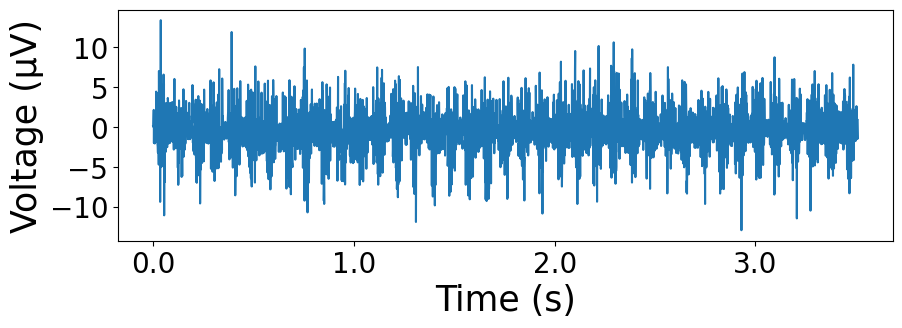

In [ ]:
from scipy import signal

spec_recon = out[0].cpu().numpy().squeeze()
_, xrec = signal.istft(spec_recon, 1000)

plt.figure(figsize=(10,3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
plt.xticks(np.arange(0,len(wav)+1, 1000), [x/1000 for x in np.arange(0,len(wav)+1, 1000)])
plt.xlabel("Time (s)", fontsize=25)
plt.plot(xrec)

In [ ]:
import mne

raw = mne.io.read_raw_edf("/mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/AR2_A_ave.edf", preload=True)

Extracting EDF parameters from /mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/AR2_A_ave.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11097999  =      0.000 ...  5548.999 secs...


In [ ]:
# Data was high-pass filtered at 0.1Hz. Line noise at 60Hz and its harmonics were removed. Each
# electrode was re-referenced by subtracting out the mean signal from the two adjacent electrodes on
# the same shaft (Laplacian re-referencing)

data = raw.filter(0.1, None, fir_design='firwin')
data = data.notch_filter(np.arange(60, 241, 60), fir_design='firwin')

In [ ]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: POL G1, POL G2, POL G3, POL G4, POL G5, POL G6, POL G7, POL G8, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2020-08-24 13:04:53 UTC
 nchan: 40
 projs: []
 sfreq: 2000.0 Hz
>

In [ ]:
laplacian = mne.preprocessing.compute_current_source_density(raw, lambda2=1e-5)


RuntimeError: Cannot fit headshape without digitization , info["dig"] is None

In [ ]:
laplacian

In [ ]:
import pandas as pd

labels = pd.read_csv("/mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/label.csv")
labels

,patient_name,channel_name,start,end,detector_type,artifact,spike,duration,SOZ,Resection,bad,label,index
0,Pt1_AR,POL G6,3346131.0,3346151.0,mni,1.0,1.0,20.0,0,1,0,1,0
1,Pt1_AR,POL G6,4233752.0,4233768.0,mni,1.0,1.0,16.0,0,1,0,1,1
2,Pt1_AR,POL G6,4297073.0,4297089.0,mni,1.0,1.0,16.0,0,1,0,1,2
3,Pt1_AR,POL G6,4347712.0,4347724.0,mni,1.0,1.0,12.0,0,1,0,1,3
4,Pt1_AR,POL G6,4487785.0,4487802.0,mni,1.0,1.0,17.0,0,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Pt1_AR,POL PD4,1540434.0,1540464.0,ste,1.0,0.0,30.0,0,0,0,0,678
679,Pt1_AR,POL PD4,1540499.0,1540534.0,ste,1.0,0.0,35.0,0,0,0,0,679
680,Pt1_AR,POL PD4,1621149.0,1621175.0,ste,0.0,-1.0,26.0,0,0,0,0,680
681,Pt1_AR,POL PD4,2042281.0,2042307.0,ste,0.0,-1.0,26.0,0,0,0,0,681


(array([642.,   3.,   3.,   2.,   6.,   6.,   9.,   5.,   3.,   4.]),
 array([0.011 , 0.1073, 0.2036, 0.2999, 0.3962, 0.4925, 0.5888, 0.6851,
        0.7814, 0.8777, 0.974 ]),
 <BarContainer object of 10 artists>)

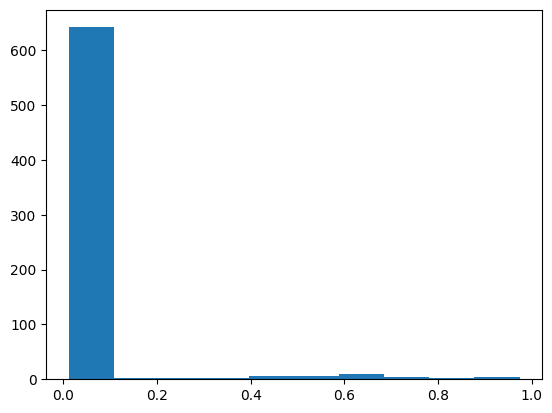

In [ ]:
plt.hist((labels["end"].values - labels["start"].values) / 1000)

In [ ]:
inputs.shape, out.shape

NameError: name 'inputs' is not defined